In [109]:
# --- Manejo de datos ---
import pandas as pd
import numpy as np
import geopandas as gpd

# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import HeatMap
# --- Preprocesamiento ---
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# --- Modelado (Clasificación y Clustering) ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# --- Evaluación de modelos ---
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# --- Configuración general ---
pd.set_option('display.max_columns', None)

# --- Suprimir advertencias ---
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import zscore
from scipy.stats import zscore
import folium

In [110]:
df = pd.read_pickle("data/df_EDA.pkl")

In [111]:
df.info(3)

<class 'pandas.core.frame.DataFrame'>
Index: 8316782 entries, 0 to 8316828
Data columns (total 23 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   case_number           object 
 2   block                 object 
 3   iucr                  object 
 4   primary_type          object 
 5   description           object 
 6   location_description  object 
 7   arrest                int64  
 8   domestic              int64  
 9   beat                  int64  
 10  district              float64
 11  ward                  float64
 12  community_area        float64
 13  fbi_code              object 
 14  x_coordinate          float64
 15  y_coordinate          float64
 16  year                  int64  
 17  latitude              float64
 18  longitude             float64
 19  date_only             object 
 20  time_only             object 
 21  updated_on_only       object 
 22  updated_on_time_only  object 
dtypes: float64(7

# Group by
## Sistema de Clasificación IUCR

El Chicago Police Department utiliza el sistema de codificación Illinois Uniform Crime Reporting (IUCR), el cual se alinea con las directrices del FBI para el reporte uniforme de crímenes. Este sistema categoriza las infracciones en dos grandes grupos: delitos índice (Index crimes) y delitos no índice (Non-Index crimes). 

 📌 *Este análisis fue recomendado y desarrollado en colaboración con Baudilio Marquez, quien ha contribuido significativamente a la comprensión del sistema IUCR en el contexto de nuestro proyecto conjunto.*


a. Delitos Índice (Index Crimes)

In [112]:
df['primary_type'].value_counts()

primary_type
THEFT                                1763501
BATTERY                              1515233
CRIMINAL DAMAGE                       945912
NARCOTICS                             760775
ASSAULT                               554437
OTHER OFFENSE                         518206
BURGLARY                              440837
MOTOR VEHICLE THEFT                   423066
DECEPTIVE PRACTICE                    381009
ROBBERY                               311846
CRIMINAL TRESPASS                     224346
WEAPONS VIOLATION                     122357
PROSTITUTION                           70317
OFFENSE INVOLVING CHILDREN             59683
PUBLIC PEACE VIOLATION                 54266
SEX OFFENSE                            33598
CRIM SEXUAL ASSAULT                    27323
INTERFERENCE WITH PUBLIC OFFICER       19820
LIQUOR LAW VIOLATION                   15305
GAMBLING                               14657
ARSON                                  14257
HOMICIDE                               137

In [113]:
#creo una lista con los delitos mas graves y mas frecuentes para filtrar el dataframe
index_crimes = {
   "HOMICIDE": "Violento",
    "CRIMINAL SEXUAL ASSAULT": "Violento",
    "ROBBERY": "Violento",
    "AGGRAVATED ASSAULT": "Violento",
    "AGGRAVATED BATTERY": "Violento",
    "BURGLARY": "Contra la propiedad",
    "THEFT": "Contra la propiedad",
    "MOTOR VEHICLE THEFT": "Contra la propiedad",
    "ARSON": "Incendio"
}
df_index=df[df['primary_type'].isin(index_crimes)].copy()

In [114]:
df_index.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2977917 entries, 4 to 8316827
Data columns (total 23 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   case_number           object 
 2   block                 object 
 3   iucr                  object 
 4   primary_type          object 
 5   description           object 
 6   location_description  object 
 7   arrest                int64  
 8   domestic              int64  
 9   beat                  int64  
 10  district              float64
 11  ward                  float64
 12  community_area        float64
 13  fbi_code              object 
 14  x_coordinate          float64
 15  y_coordinate          float64
 16  year                  int64  
 17  latitude              float64
 18  longitude             float64
 19  date_only             object 
 20  time_only             object 
 21  updated_on_only       object 
 22  updated_on_time_only  object 
dtypes: float64(7

In [115]:
df_index.head(5)

,id,case_number,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,latitude,longitude,date_only,time_only,updated_on_only,updated_on_time_only
4,13204489,JG416325,0000X E 8TH ST,0810,THEFT,OVER $500,PARKING LOT / GARAGE (NON RESIDENTIAL),0,0,123,1.0,4.0,32.0,06,1176857.0,1896680.0,2023,41.871835,-87.626151,2023-09-06,11:00:00,2023-11-04,15:40:18
5,11695116,JC272771,018XX S CALIFORNIA AVE,0620,BURGLARY,UNLAWFUL ENTRY,RESIDENCE,0,0,1023,10.0,25.0,29.0,05,1157982.0,1890961.0,2019,41.856547,-87.695605,2019-05-21,08:20:00,2024-01-19,15:40:50
7,12729745,JF279458,035XX N CENTRAL AVE,0340,ROBBERY,ATTEMPT STRONG ARM - NO WEAPON,BANK,1,0,1633,16.0,30.0,15.0,03,1138391.0,1923142.0,2022,41.945232,-87.766735,2022-06-14,14:47:00,2024-01-19,15:40:50
8,12835559,JF406130,004XX E 69TH ST,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,OTHER (SPECIFY),1,0,322,3.0,6.0,69.0,07,1180204.0,1859359.0,2022,41.769347,-87.615008,2022-09-21,22:00:00,2024-01-19,15:40:50
9,13003649,JG177593,070XX S CLYDE AVE,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE - PORCH / HALLWAY,1,0,331,3.0,5.0,43.0,05,1191427.0,1858753.0,2023,41.767419,-87.573890,2023-02-22,13:50:00,2024-01-19,15:40:50


In [116]:
df_index.describe()

,id,arrest,domestic,beat,district,ward,community_area,x_coordinate,y_coordinate,year,latitude,longitude
count,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06
mean,7.531789e+06,9.644762e-02,2.785000e-02,1.225664e+03,1.167372e+01,2.409655e+01,3.472932e+01,1.165110e+06,1.888865e+06,2.011050e+03,4.185063e+01,-8.766953e+01
std,3.759945e+06,2.952042e-01,1.645430e-01,7.197445e+02,7.130026e+00,1.408930e+01,2.125376e+01,1.672714e+04,3.262002e+04,6.991082e+00,8.974492e-02,6.052591e-02
min,6.340000e+02,0.000000e+00,0.000000e+00,1.110000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.001000e+03,3.661945e+01,-9.168657e+01
25%,4.122996e+06,0.000000e+00,0.000000e+00,6.230000e+02,6.000000e+00,1.100000e+01,2.200000e+01,1.154765e+06,1.861276e+06,2.005000e+03,4.177497e+01,-8.770723e+01
50%,7.647837e+06,0.000000e+00,0.000000e+00,1.132000e+03,1.100000e+01,2.600000e+01,2.800000e+01,1.166601e+06,1.896142e+06,2.010000e+03,4.187082e+01,-8.766404e+01
75%,1.087291e+07,0.000000e+00,0.000000e+00,1.824000e+03,1.800000e+01,3.500000e+01,5.000000e+01,1.176338e+06,1.912459e+06,2.017000e+03,4.191559e+01,-8.762834e+01
max,1.383938e+07,1.000000e+00,1.000000e+00,2.535000e+03,3.100000e+01,5.000000e+01,7.700000e+01,1.205119e+06,1.951622e+06,2.025000e+03,4.202291e+01,-8.752453e+01


Porcentaje de arrestos para cada tipo de delito INDEX_CRIMES


In [117]:
df_index.groupby("primary_type")["arrest"].mean().sort_values(ascending=False)

primary_type
HOMICIDE                   0.478672
ARSON                      0.122887
THEFT                      0.108694
ROBBERY                    0.092453
MOTOR VEHICLE THEFT        0.076485
CRIMINAL SEXUAL ASSAULT    0.073340
BURGLARY                   0.057214
Name: arrest, dtype: float64

In [118]:
#he generado una nueva columna 'arrest_mean' que contiene el pormedio de arrestos por los delitos mas graves
df_index['arrest_mean']=df_index['arrest'].mean()

In [119]:
arrest_rate = df_index['arrest'].mean()
print(arrest_rate)

0.09644761757967062


## Análisis espacial

Lugar mas frecuente por tipo de delito

In [120]:
#con esta instruccion quiero hacer un analiss espacial de los delitos mas graves y frecuentes
df_index.groupby("primary_type")["location_description"].agg(lambda x: x.mode().iloc[0])

primary_type
ARSON                      VEHICLE NON-COMMERCIAL
BURGLARY                                RESIDENCE
CRIMINAL SEXUAL ASSAULT                 APARTMENT
HOMICIDE                                   STREET
MOTOR VEHICLE THEFT                        STREET
ROBBERY                                    STREET
THEFT                                      STREET
Name: location_description, dtype: object

Moda de location_description por tipo de delito

In [121]:
moda_localizacion = df_index.groupby("primary_type")["location_description"]\
    .agg(lambda x: x.mode().iloc[0]).reset_index(name="location_mode")

Calculo de coordenadas medias para cada tipo de delito y lugar
con esto quiero ver el lugar promedio de cada uno de los eventos 

In [122]:
coordenadas = df_index.groupby(["primary_type", "location_description"])[["latitude", "longitude"]]\
    .mean().reset_index()

# Uno para quedarnos solo con la moda y su ubicación media
df_mapa = moda_localizacion.merge(coordenadas,
                                   left_on=["primary_type", "location_mode"],
                                   right_on=["primary_type", "location_description"])

In [123]:
# Centro del mapa (Chicago)
map_center = [41.88, -87.63]
m = folium.Map(location=map_center, zoom_start=11)

# Dibujo cada moda de localización como un punto rojo
for _, row in df_mapa.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.8,
        popup=f"{row['primary_type']}: {row['location_mode']}"
    ).add_to(m)

m

In [124]:
df_index[['latitude','longitude']].describe()

,latitude,longitude
count,2.977917e+06,2.977917e+06
mean,4.185063e+01,-8.766953e+01
std,8.974492e-02,6.052591e-02
min,3.661945e+01,-9.168657e+01
25%,4.177497e+01,-8.770723e+01
50%,4.187082e+01,-8.766404e+01
75%,4.191559e+01,-8.762834e+01
max,4.202291e+01,-8.752453e+01


In [125]:
#El valor mínimo de latitud ( min = 36.61) y longitud ( min = -91.68)
#  están muy lejos de Chicago (probablemente errores de geocodificación o datos mal cargados
# Filtro solo los datos dentro del rango esperado para Chicago
df_chicago = df_index[
    (df_index['latitude'] >= 41.6) & (df_index['latitude'] <= 42.1) &
    (df_index['longitude'] >= -88) & (df_index['longitude'] <= -87.3)
]

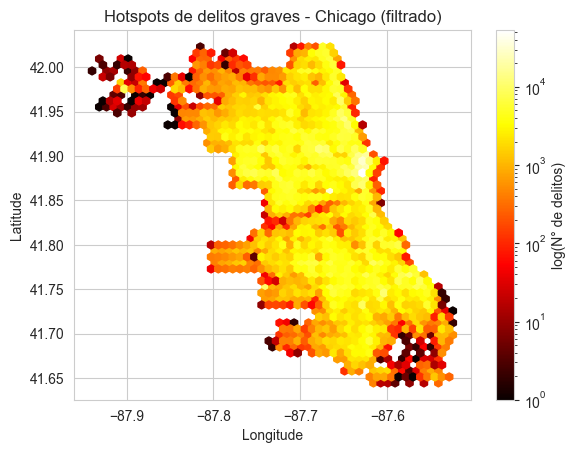

In [126]:
plt.hexbin(df_chicago['longitude'], df_chicago['latitude'], gridsize=50, cmap='hot', bins='log')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hotspots de delitos graves - Chicago (filtrado)')
plt.colorbar(label='log(N° de delitos)')
plt.show()

Lugares donde ocurren mas delitos

In [127]:
#con esta instruccion filtro los 10 lugares mas comunes donde ocurren los delitros graves
top_locations = df_index["location_description"].value_counts().head(10).index
#ahora quiero filtrar el dataframe para quedarme solo con los delitos que ocurren en sos lugares
df_top_loc = df_index[df_index["location_description"].isin(top_locations)]

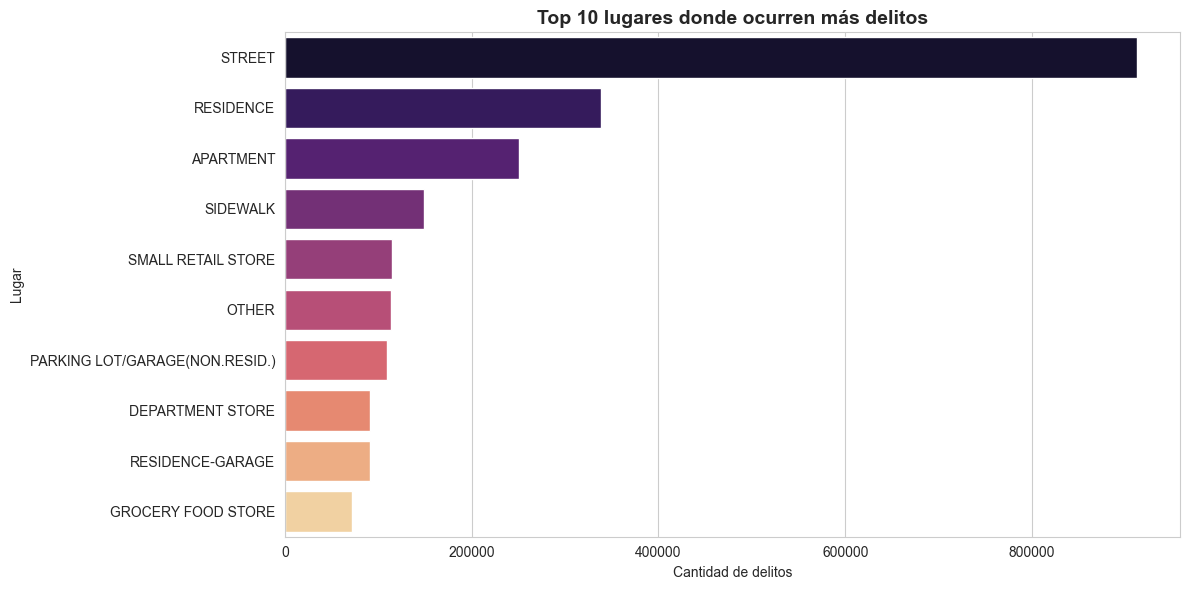

In [128]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_top_loc,
    y="location_description",
    order=top_locations,
    palette="magma"
)

plt.title("Top 10 lugares donde ocurren más delitos", fontsize=14, fontweight="bold")
plt.xlabel("Cantidad de delitos")
plt.ylabel("Lugar")
plt.tight_layout()
plt.show()


Resumen estadístico general de arrestos y ubicaciones

In [129]:
df_index[["arrest", "latitude", "longitude"]].describe()

,arrest,latitude,longitude
count,2.977917e+06,2.977917e+06,2.977917e+06
mean,9.644762e-02,4.185063e+01,-8.766953e+01
std,2.952042e-01,8.974492e-02,6.052591e-02
min,0.000000e+00,3.661945e+01,-9.168657e+01
25%,0.000000e+00,4.177497e+01,-8.770723e+01
50%,0.000000e+00,4.187082e+01,-8.766404e+01
75%,0.000000e+00,4.191559e+01,-8.762834e+01
max,1.000000e+00,4.202291e+01,-8.752453e+01


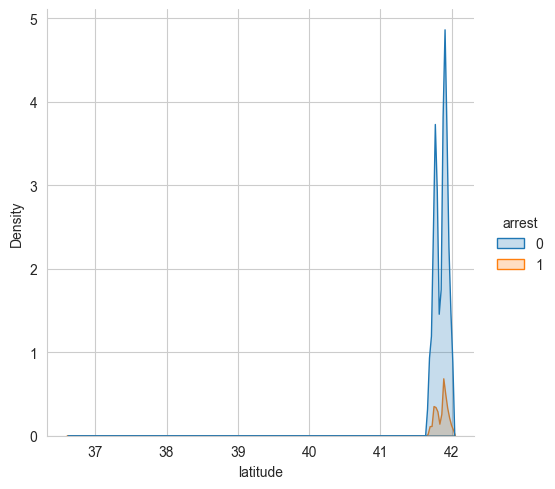

In [130]:
#con esta instruccion quiero obervar la distribucion de delitos segun la laititus y los arrestos
sns.displot(df_index, x="latitude", hue="arrest", kind="kde", fill=True)

Calles con mas delitos

In [131]:
df_index['block'].value_counts().head(10)

block
001XX N STATE ST        11945
076XX S CICERO AVE       8551
0000X N STATE ST         8507
008XX N MICHIGAN AVE     7406
100XX W OHARE ST         6809
0000X S STATE ST         3372
006XX N MICHIGAN AVE     3295
001XX W 87TH ST          3280
046XX W NORTH AVE        3129
026XX N ELSTON AVE       3018
Name: count, dtype: int64

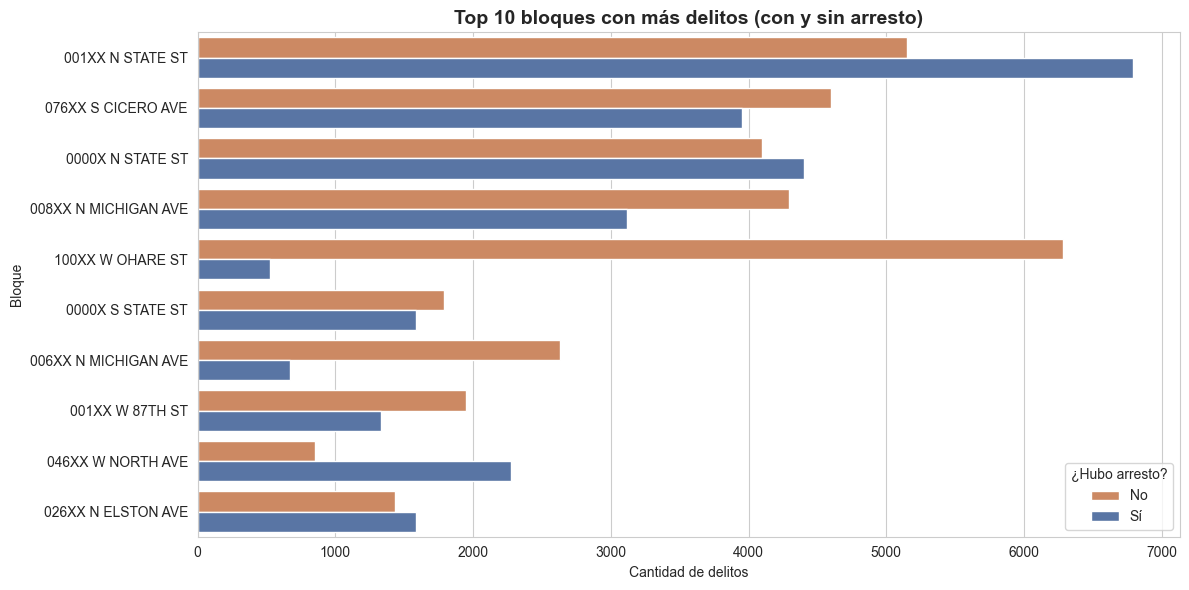

In [132]:
top_blocks = df_index["block"].value_counts().head(10).index
df_top = df_index[df_index["block"].isin(top_blocks)]

custom_palette = {True: "#4C72B0", False: "#DD8452"} # Azul y rojo fuertes

# Gráfico
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_top,
    y="block",
    hue="arrest",
    order=top_blocks,
    palette=custom_palette
)

plt.title("Top 10 bloques con más delitos (con y sin arresto)", fontsize=14, fontweight="bold")
plt.xlabel("Cantidad de delitos")
plt.ylabel("Bloque")
plt.legend(title="¿Hubo arresto?", labels=["No", "Sí"])
plt.tight_layout()
plt.show()

Conteo de delito por tipo principal

In [133]:

df_index.groupby('primary_type')[['block']].count()


,block
primary_type,
ARSON,14257
BURGLARY,440837
CRIMINAL SEXUAL ASSAULT,10649
HOMICIDE,13761
MOTOR VEHICLE THEFT,423066
ROBBERY,311846
THEFT,1763501


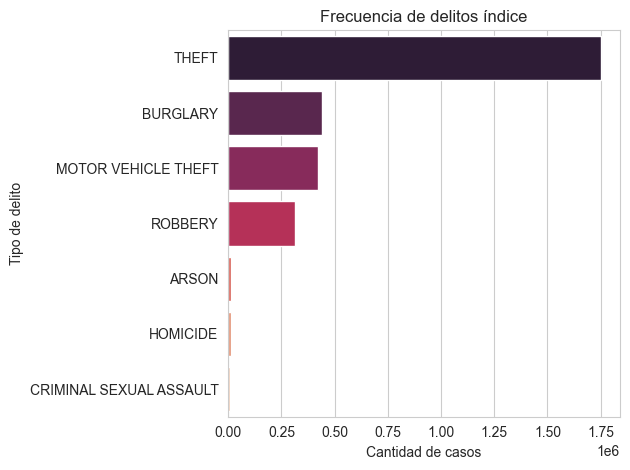

In [134]:
# Datos agrupados
counts = {
    'ARSON': 14256,
    'BURGLARY': 440772,
    'CRIMINAL SEXUAL ASSAULT': 10631,
    'HOMICIDE': 13724,
    'MOTOR VEHICLE THEFT': 421767,
    'ROBBERY': 311783,
    'THEFT': 1752953
}

df_counts = pd.DataFrame(list(counts.items()), columns=["primary_type", "count"])
df_counts = df_counts.sort_values("count", ascending=False)
# Barplot
sns.barplot(data=df_counts, x="count", y="primary_type", palette="rocket")
plt.title("Frecuencia de delitos índice")
plt.xlabel("Cantidad de casos")
plt.ylabel("Tipo de delito")
plt.tight_layout()
plt.show()

In [135]:
df_index.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2977917 entries, 4 to 8316827
Data columns (total 24 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   case_number           object 
 2   block                 object 
 3   iucr                  object 
 4   primary_type          object 
 5   description           object 
 6   location_description  object 
 7   arrest                int64  
 8   domestic              int64  
 9   beat                  int64  
 10  district              float64
 11  ward                  float64
 12  community_area        float64
 13  fbi_code              object 
 14  x_coordinate          float64
 15  y_coordinate          float64
 16  year                  int64  
 17  latitude              float64
 18  longitude             float64
 19  date_only             object 
 20  time_only             object 
 21  updated_on_only       object 
 22  updated_on_time_only  object 
 23  arrest_mean 

## Analisis temporal

1. Delitos por año 

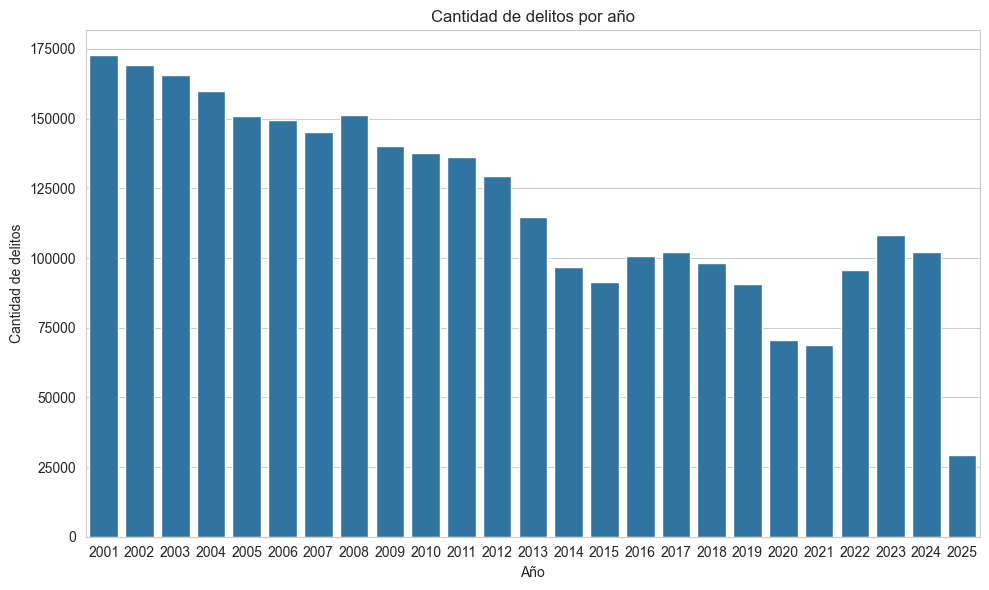

In [136]:
delitosIndex_por_año=df_index['year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=delitosIndex_por_año.index, y=delitosIndex_por_año.values)
plt.title("Cantidad de delitos por año")
plt.xlabel("Año")     
plt.ylabel("Cantidad de delitos")
plt.tight_layout()
plt.show()

2. Delitos por mes (tendencia estacional)
Ahora veremos como varian los delitos por mes

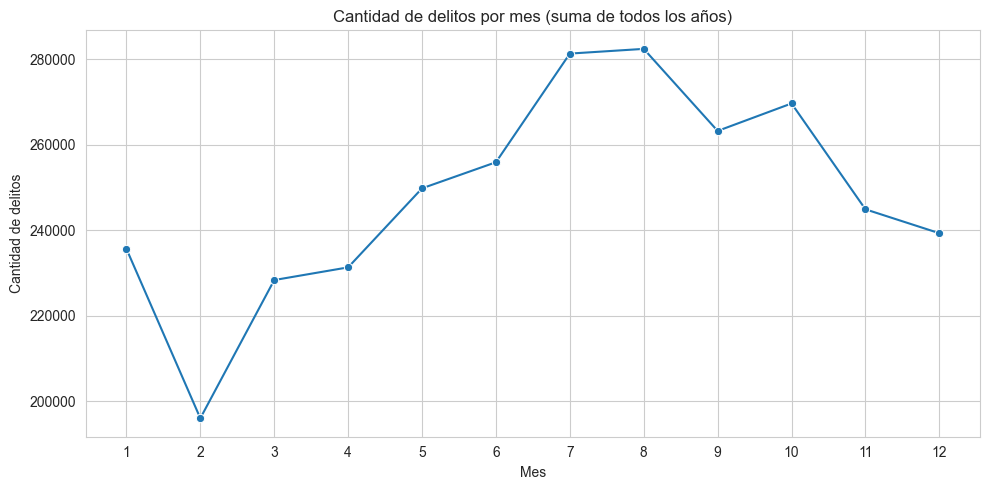

In [137]:
# columna 'date_only' en formato datetime
df_index['date_only'] = pd.to_datetime(df_index['date_only'], errors='coerce')

# Extraigo el mes
df_index['month'] = df_index['date_only'].dt.month

# Agrupo por mes los datos
delitosIndex_por_mes = df_index['month'].value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.lineplot(x=delitosIndex_por_mes.index, y=delitosIndex_por_mes.values, marker='o')
plt.title('Cantidad de delitos por mes (suma de todos los años)')
plt.xlabel('Mes')
plt.ylabel('Cantidad de delitos')
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()

3. Delitos por día de la semana


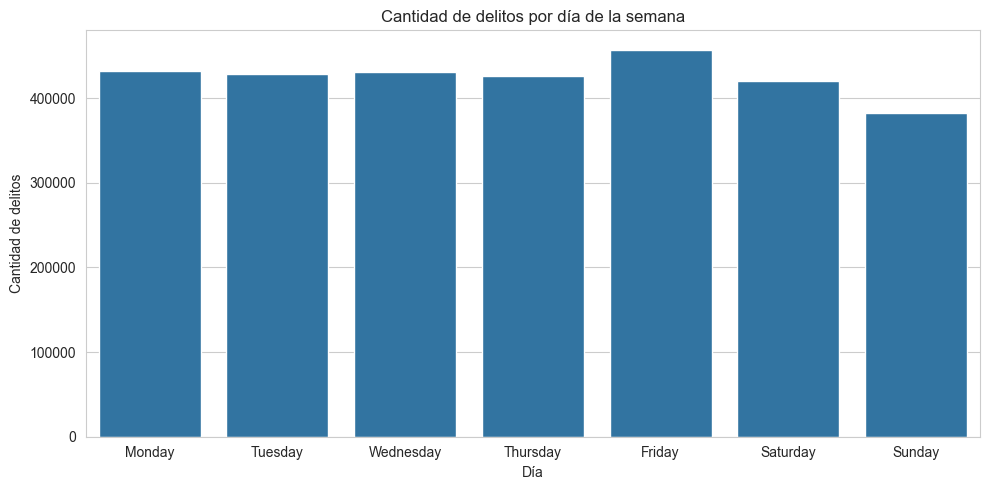

In [138]:
df_index['day_of_week'] = pd.to_datetime(df_index['date_only']).dt.day_name()

# Orden lógico de los días
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

delitos_por_dia = df_index['day_of_week'].value_counts().reindex(dias_orden)

plt.figure(figsize=(10,5))
sns.barplot(x=delitos_por_dia.index, y=delitos_por_dia.values)
plt.title('Cantidad de delitos por día de la semana')
plt.xlabel('Día')
plt.ylabel('Cantidad de delitos')
plt.tight_layout()
plt.show()

4.Frecuencia de delito por hora (extraigo otro formato numerico)
Esto me permite detectar las horas pico

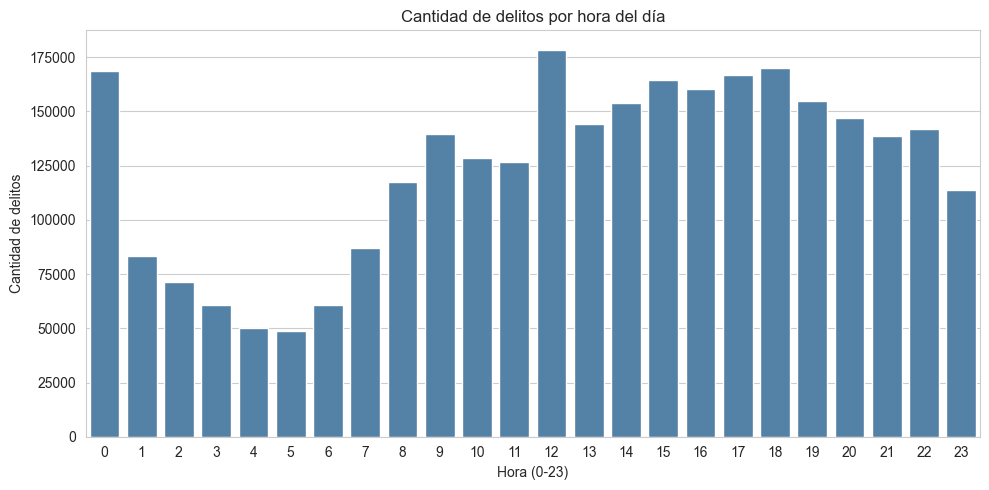

In [139]:
# Extraer la hora de la columna 'time_only' si no existe la columna 'hour'
if 'hour' not in df_index.columns:
	df_index['hour'] = pd.to_datetime(df_index['time_only'], errors='coerce').dt.hour

delitos_por_hora = df_index['hour'].value_counts().sort_index()

plt.figure(figsize=(10,5))
sns.barplot(x=delitos_por_hora.index, y=delitos_por_hora.values, color='steelblue')
plt.title('Cantidad de delitos por hora del día')
plt.xlabel('Hora (0-23)')
plt.ylabel('Cantidad de delitos')
plt.tight_layout()
plt.show()

Detectar patrones nocturnos vs. diurnos

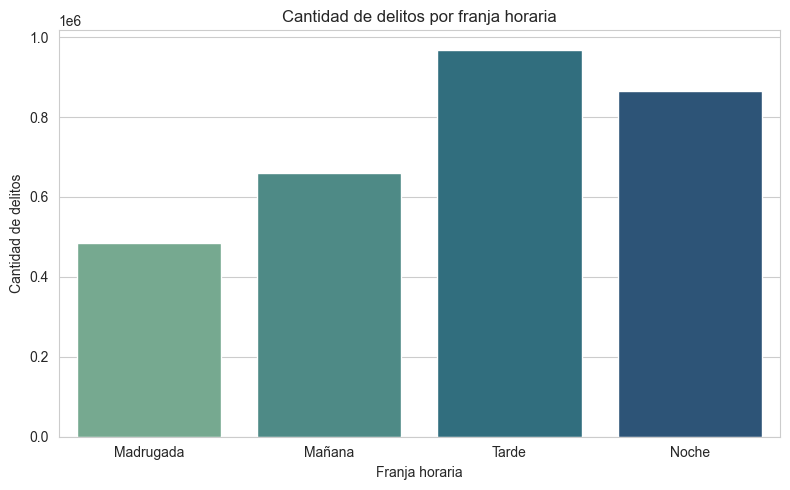

In [140]:
# Defino franjas horarias
def categoria_franga_horaria(hora):
    if 6 <= hora < 12:
        return 'Mañana'
    elif 12 <= hora < 18:
        return 'Tarde'
    elif 18 <= hora < 24:
        return 'Noche'
    else:
        return 'Madrugada'

df_index['franja_horaria'] = df_index['hour'].apply(categoria_franga_horaria)

# Cuento delitos por franja horaria
delitos_por_franja = df_index['franja_horaria'].value_counts().reindex(['Madrugada','Mañana','Tarde','Noche'])

plt.figure(figsize=(8,5))
sns.barplot(x=delitos_por_franja.index, y=delitos_por_franja.values, palette='crest')
plt.title('Cantidad de delitos por franja horaria')
plt.xlabel('Franja horaria')
plt.ylabel('Cantidad de delitos')
plt.tight_layout()
plt.show()

In [141]:
df_index.head(5)

,id,case_number,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,latitude,longitude,date_only,time_only,updated_on_only,updated_on_time_only,arrest_mean,month,day_of_week,hour,franja_horaria
4,13204489,JG416325,0000X E 8TH ST,0810,THEFT,OVER $500,PARKING LOT / GARAGE (NON RESIDENTIAL),0,0,123,1.0,4.0,32.0,06,1176857.0,1896680.0,2023,41.871835,-87.626151,2023-09-06,11:00:00,2023-11-04,15:40:18,0.096448,9,Wednesday,11,Mañana
5,11695116,JC272771,018XX S CALIFORNIA AVE,0620,BURGLARY,UNLAWFUL ENTRY,RESIDENCE,0,0,1023,10.0,25.0,29.0,05,1157982.0,1890961.0,2019,41.856547,-87.695605,2019-05-21,08:20:00,2024-01-19,15:40:50,0.096448,5,Tuesday,8,Mañana
7,12729745,JF279458,035XX N CENTRAL AVE,0340,ROBBERY,ATTEMPT STRONG ARM - NO WEAPON,BANK,1,0,1633,16.0,30.0,15.0,03,1138391.0,1923142.0,2022,41.945232,-87.766735,2022-06-14,14:47:00,2024-01-19,15:40:50,0.096448,6,Tuesday,14,Tarde
8,12835559,JF406130,004XX E 69TH ST,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,OTHER (SPECIFY),1,0,322,3.0,6.0,69.0,07,1180204.0,1859359.0,2022,41.769347,-87.615008,2022-09-21,22:00:00,2024-01-19,15:40:50,0.096448,9,Wednesday,22,Noche
9,13003649,JG177593,070XX S CLYDE AVE,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE - PORCH / HALLWAY,1,0,331,3.0,5.0,43.0,05,1191427.0,1858753.0,2023,41.767419,-87.573890,2023-02-22,13:50:00,2024-01-19,15:40:50,0.096448,2,Wednesday,13,Tarde


## Modelo

In [142]:
vars_cluster = ['hour', 'day_of_week', 'primary_type', 'district', 'domestic', 'arrest_mean']

df_cluster = df_index[vars_cluster].copy()
df_cluster.head()

,hour,day_of_week,primary_type,district,domestic,arrest_mean
4,11,Wednesday,THEFT,1.0,0,0.096448
5,8,Tuesday,BURGLARY,10.0,0,0.096448
7,14,Tuesday,ROBBERY,16.0,0,0.096448
8,22,Wednesday,MOTOR VEHICLE THEFT,3.0,0,0.096448
9,13,Wednesday,BURGLARY,3.0,0,0.096448


In [143]:
df_cluster = pd.get_dummies(df_cluster, drop_first=True)
df_cluster.head()

,hour,district,domestic,arrest_mean,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,primary_type_BURGLARY,primary_type_CRIMINAL SEXUAL ASSAULT,primary_type_HOMICIDE,primary_type_MOTOR VEHICLE THEFT,primary_type_ROBBERY,primary_type_THEFT
4,11,1.0,0,0.096448,False,False,False,False,False,True,False,False,False,False,False,True
5,8,10.0,0,0.096448,False,False,False,False,True,False,True,False,False,False,False,False
7,14,16.0,0,0.096448,False,False,False,False,True,False,False,False,False,False,True,False
8,22,3.0,0,0.096448,False,False,False,False,False,True,False,False,False,True,False,False
9,13,3.0,0,0.096448,False,False,False,False,False,True,True,False,False,False,False,False


Escalar todas las variables numéricas

In [144]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

Elección del número de clusters

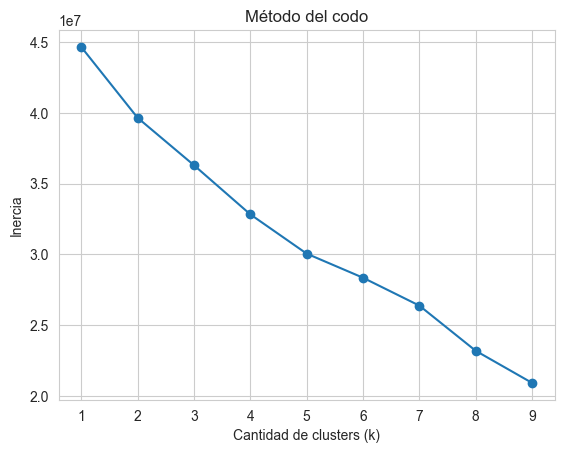

In [145]:
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, '-o')
plt.xlabel('Cantidad de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo')
plt.show()

## Primer cluster

In [146]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_index['cluster'] = kmeans.fit_predict(X_scaled)

In [147]:
# ¿Cuántos incidentes hay en cada cluster?
print(df_index['cluster'].value_counts())

# ¿Cómo se distribuyen por tipo de delito y franja horaria?
pd.crosstab(df_index['cluster'], df_index['primary_type'])

# Por franja horaria:
pd.crosstab(df_index['cluster'], df_index['franja_horaria'])

cluster
3    1777758
1     447476
2     440837
0     311846
Name: count, dtype: int64


franja_horaria,Madrugada,Mañana,Noche,Tarde
cluster,,,,
0,74118,45207,110029,82492
1,89621,87575,164557,105723
2,73636,133865,103706,129630
3,246318,393397,487627,650416


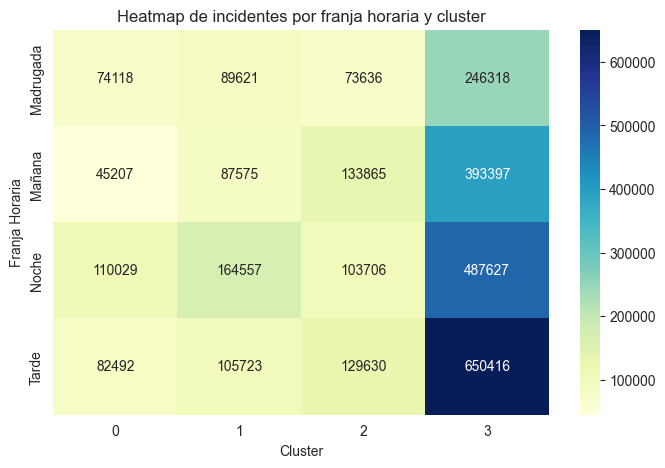

In [148]:
plt.figure(figsize=(8,5))
tabla = pd.crosstab(df_index['franja_horaria'], df_index['cluster'])
sns.heatmap(tabla, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Heatmap de incidentes por franja horaria y cluster')
plt.ylabel('Franja Horaria')
plt.xlabel('Cluster')
plt.show()

 **Heatmap de incidentes por franja horaria y cluster**
 
Este gráfico de calor muestra la cantidad de incidentes registrados en cada franja horaria (Madrugada, Mañana, Noche, Tarde) para cada cluster identificado por el análisis K-Means.

Cluster 3 concentra la mayor cantidad de incidentes en todas las franjas horarias, especialmente en la tarde (650,416) y la noche (487,627).
Los valores de incidentes son notablemente más altos en este cluster en comparación con los demás.

Cluster 2 y Cluster 1 presentan cantidades moderadas de incidentes, siendo la mañana y la tarde sus franjas más relevantes.

Cluster 0 tiene la menor cantidad de incidentes en todas las franjas, aunque destaca un poco más en la noche (110,029).

La intensidad del color en el heatmap permite visualizar rápidamente dónde se concentran los incidentes, siendo el azul más oscuro indicador de mayor cantidad.

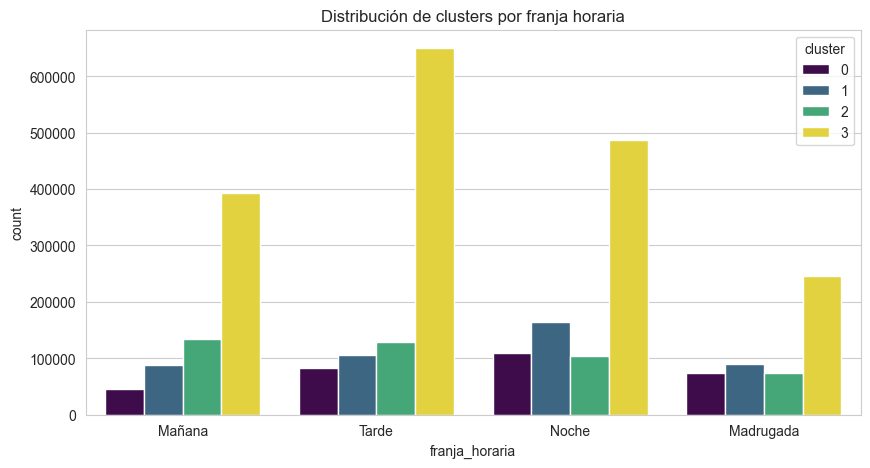

In [149]:
plt.figure(figsize=(10,5)) 
sns.countplot(data=df_index, x='franja_horaria', hue='cluster',palette='viridis')
plt.title('Distribución de clusters por franja horaria') 
plt.show() 

**Distribución de clusters por franja horaria**

Este gráfico de barras muestra la distribución de incidentes agrupados por cluster y franja horaria:

Se observa que Cluster 3 (color amarillo) es el más numeroso en todas las franjas horarias, con un pico especialmente alto en la tarde y la noche.

Los clusters 1 y 2 tienen una distribución más equilibrada entre mañana, tarde y noche, pero nunca superan la cantidad de incidentes de Cluster 3.

Cluster 0 (color violeta oscuro) es consistentemente el menos numeroso en todas las franjas horarias.

El gráfico facilita comparar rápidamente la frecuencia de incidentes entre franjas y clusters, mostrando que la tarde y la noche son los horarios donde se concentra la mayoría de los delitos, especialmente en Cluster 3.

**Tabla de contingencia**

muestra la cantidad de incidentes para cada combinación de cluster y tipo de delito.

In [150]:
pd.crosstab(df_index['cluster'], df_index['primary_type'])

primary_type,ARSON,BURGLARY,CRIMINAL SEXUAL ASSAULT,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,THEFT
cluster,,,,,,,
0,0,0,0,0,0,311846,0
1,0,0,10649,13761,423066,0,0
2,0,440837,0,0,0,0,0
3,14257,0,0,0,0,0,1763501


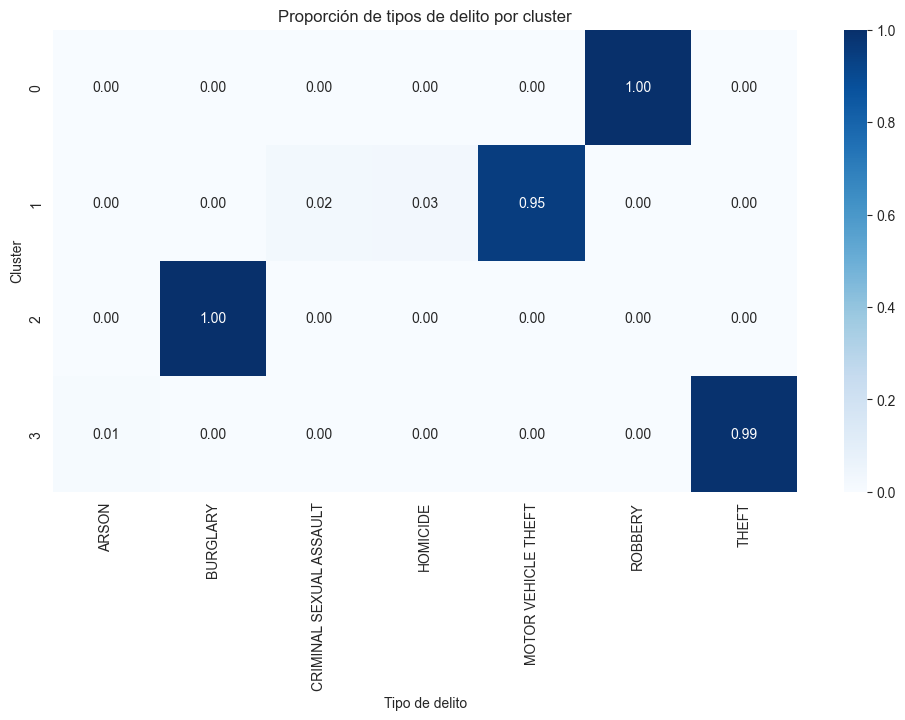

In [151]:
tabla = pd.crosstab(df_index['cluster'], df_index['primary_type'], normalize='index')
plt.figure(figsize=(12,6))
sns.heatmap(tabla, annot=True, fmt=".2f", cmap='Blues')
plt.title('Proporción de tipos de delito por cluster')
plt.ylabel('Cluster')
plt.xlabel('Tipo de delito')
plt.show()

## Interpretación del análisis de clusters según tipo de delito

Cluster 0: Agrupa solo robos en la vía pública (ROBBERY).

Cluster 1: Agrupa principalmente robos de vehículos (MOTOR VEHICLE THEFT), y también algunos casos de asalto sexual y homicidio.

Cluster 2: Es exclusivo de robos a viviendas o locales (BURGLARY).

Cluster 3: Agrupa casi todos los robos generales (THEFT), con unos pocos incendios (ARSON).

Cada cluster agrupa un tipo de delito diferente. Esto ayuda a entender qué delitos son más frecuentes y cómo se relacionan entre sí.

 ## Agrupación por modus operandi

In [152]:
# 1. Variables para el clustering (puedo ajustar a las columnas reales)

if 'hour' not in df.columns:
	df['hour'] = pd.to_datetime(df['time_only'], errors='coerce').dt.hour
if 'day_of_week' not in df.columns:
	df['day_of_week'] = pd.to_datetime(df['date_only'], errors='coerce').dt.day_name()


vars_mo = ['primary_type', 'location_description', 'hour', 'day_of_week', 'domestic']

# 2. Tomo una muestra aleatoria (esto es solo para acelerar el cómputo)
n_samples = min(100000, df.shape[0])
rng = np.random.default_rng()
sample_idx = rng.choice(df.dropna(subset=vars_mo).index, size=n_samples, replace=False)
df_sample = df.loc[sample_idx, vars_mo].dropna()

# 3. Codificación one-hot (dummy variables)
df_mo_sample = pd.get_dummies(df_sample, drop_first=True, sparse=True)

# 4. Escalado
scaler = StandardScaler(with_mean=False)
X_mo_sample = scaler.fit_transform(df_mo_sample)

# 5. Clustering KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_mo_sample)

# 6. Guardo el cluster en el DataFrame original
df.loc[df_sample.index, 'mo_cluster'] = labels

In [153]:
# 7. Tabla: proporción de cada delito dentro de cada cluster
tabla = pd.crosstab(df['mo_cluster'], df['primary_type'], normalize='index')
print(tabla.round(2))  # Muestra solo dos decimales, más legible

# 8. Delito más frecuente por cluster y proporción
delito_predominante = tabla.idxmax(axis=1)
proporcion_predominante = tabla.max(axis=1)
resultado = pd.DataFrame({
    "Delito predominante": delito_predominante,
    "Proporción": proporcion_predominante.round(2)
})
print(resultado)

primary_type  ARSON  ASSAULT  BATTERY  BURGLARY  \
mo_cluster                                        
0.0             0.0     0.06     0.18      0.01   
1.0             0.0     0.09     0.57      0.10   
2.0             0.0     0.15     0.19      0.19   
3.0             0.0     0.06     0.00      0.03   

primary_type  CONCEALED CARRY LICENSE VIOLATION  CRIM SEXUAL ASSAULT  \
mo_cluster                                                             
0.0                                         0.0                 0.00   
1.0                                         0.0                 0.01   
2.0                                         0.0                 0.00   
3.0                                         0.0                 0.00   

primary_type  CRIMINAL DAMAGE  CRIMINAL SEXUAL ASSAULT  CRIMINAL TRESPASS  \
mo_cluster                                                                  
0.0                      0.04                      0.0               0.27   
1.0                      0.02

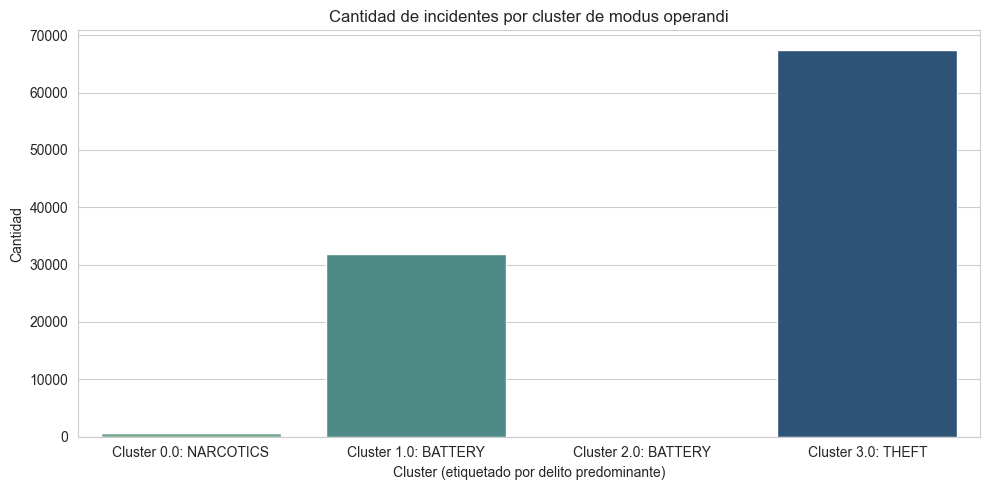

In [154]:
# 9. Gráfico: cantidad de incidentes por cluster
sns.set_style("whitegrid")
counts = df['mo_cluster'].value_counts().sort_index()
labels = [f"Cluster {i}: {resultado.loc[i, 'Delito predominante']}" for i in counts.index]

palette = sns.color_palette("crest", len(counts))
plt.figure(figsize=(10, 5))
sns.barplot(x=labels, y=counts.values, palette=palette)
plt.title("Cantidad de incidentes por cluster de modus operandi")
plt.xlabel("Cluster (etiquetado por delito predominante)")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()

## Interpretación del gráfico: cantidad de incidentes por cluster de modus operandi

Cluster 0: NARCOTICS (drogas): Es el menos numeroso, con una cantidad muy baja de incidentes.

Cluster 1: BATTERY (agresiones físicas): Tiene una cantidad de incidentes moderada, alrededor de 32,000.

Cluster 2: BATTERY: No tiene barras visibles, lo que indica que la cantidad es muy baja o nula.

Cluster 3: THEFT (robos): Es el cluster más numeroso, con cerca de 67,000 incidentes.
Conclusión:

El delito más común en los datos analizados es el robo (THEFT), seguido por las agresiones (BATTERY). Los incidentes relacionados con drogas (NARCOTICS) son los menos frecuentes entre los clusters analizados..

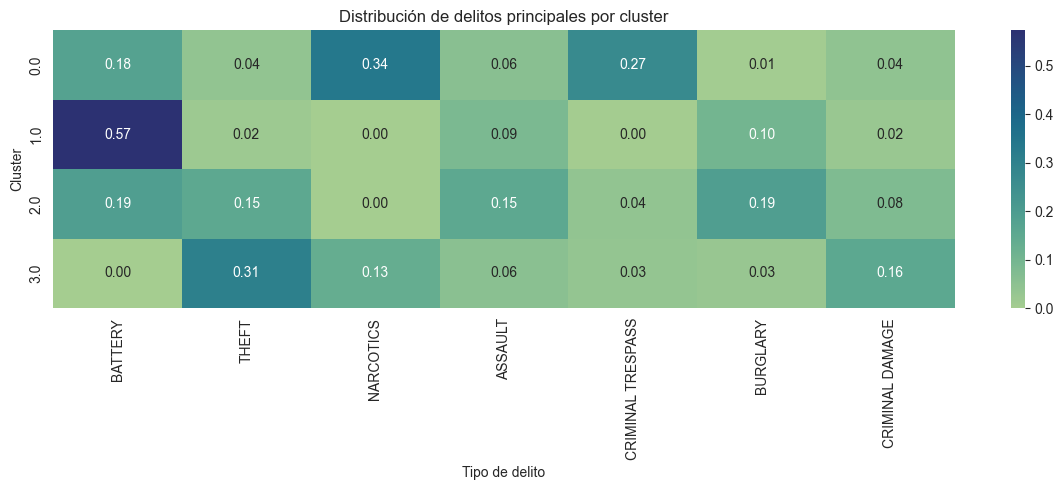

In [155]:
# 10. (Opcional) Heatmap de tipos de delito por cluster, solo los delitos principales (top 7)
top_delitos = tabla.sum().sort_values(ascending=False).head(7).index
tabla_top = tabla[top_delitos]

plt.figure(figsize=(12, 5))
sns.heatmap(tabla_top, annot=True, fmt=".2f", cmap="crest")
plt.title("Distribución de delitos principales por cluster")
plt.xlabel("Tipo de delito")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

**Análisis de mapa de calor**

_Clúster 0.0 delitos más comunes: Es un grupo variado, aunque destacan los robos y fraudes.

ROBO: 22%
PRÁCTICA ENGAÑOSA: 22%
BATERÍA (VIOLENCIA FÍSICA): 11%
NARCÓTICOS: 9%
_Clúster 1.0 delitos más comunes: Predominan los robos y los daños a la propiedad.

ROBO: 31%
BATERÍA: 11%
DAÑOS PENALES: 12%
_Clúster 3.0 delitos más comunes: Principalmente agresiones y delitos relacionados con drogas.

BATERÍA: 38%
NARCÓTICOS: 25%
OTROS DELITOS: 13%
_Clúster 4.0 delitos más comunes: Agresiones y delitos de drogas son los más frecuentes.

BATERÍA: 27%
NARCÓTICOS: 20%
OTROS DELITOS: 10%

*Conclusiones*

ROBO es el delito más común en los clústers 0 y 1, pero no es mayoría absoluta en ningún grupo.
BATERÍA (agresiones) es el principal delito en los clústers 3 y 4, seguido por NARCÓTICOS.
Todos los clústers tienen una mezcla de delitos, no hay grupos “puros” de un solo delito.




## Agrupación por contexto socio-espacial
Incluye área comunitaria, tipo de delito, hora y si fue doméstico.


In [158]:
# Coordenadas promedio por cluster
print("\nCoordenadas promedio por cluster socio-espacial:")
print(df.groupby('socio_cluster')[['latitude', 'longitude']].mean())


Coordenadas promedio por cluster socio-espacial:
                latitude  longitude
socio_cluster                      
0              41.840850 -87.682348
1              41.848652 -87.670063
2              41.838965 -87.672844
3              41.830954 -87.669119


In [156]:
vars_socio = ['community_area', 'primary_type', 'hour', 'domestic']
df_socio = pd.get_dummies(df[vars_socio].dropna(), drop_first=True)

scaler = StandardScaler()
X_socio = scaler.fit_transform(df_socio)

kmeans_socio = KMeans(n_clusters=4, random_state=42, n_init=10)
df['socio_cluster'] = kmeans_socio.fit_predict(X_socio)

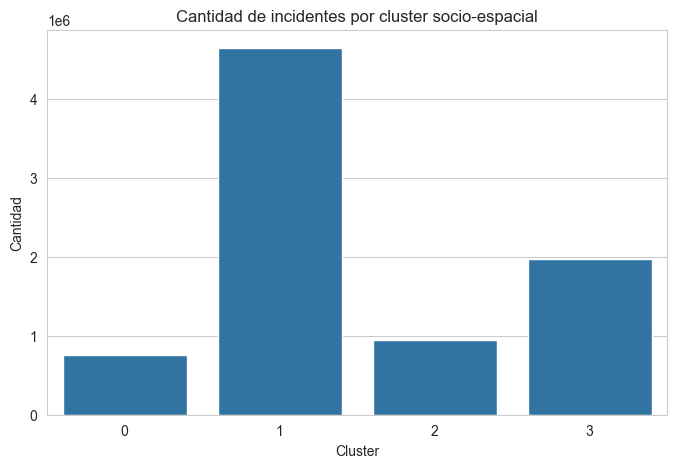

Estadísticas básicas por cluster socio-espacial:
               community_area       hour  domestic
socio_cluster                                     
0                   36.366892  15.082118  0.000808
1                   35.284289  12.938159  0.017820
2                   37.587725  12.748125  0.114894
3                   38.823751  12.808371  0.630706

Top tipos de delito por cluster:

Cluster 0:
primary_type
NARCOTICS    1.0
Name: proportion, dtype: float64

Cluster 1:
primary_type
THEFT                  0.379957
BURGLARY               0.094667
MOTOR VEHICLE THEFT    0.090984
Name: proportion, dtype: float64

Cluster 2:
primary_type
CRIMINAL DAMAGE    1.0
Name: proportion, dtype: float64

Cluster 3:
primary_type
BATTERY          0.769634
OTHER OFFENSE    0.097613
ASSAULT          0.082507
Name: proportion, dtype: float64


In [157]:
# Visualización básica: cantidad de incidentes por cluster
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='socio_cluster', order=sorted(df['socio_cluster'].dropna().unique()))
plt.title('Cantidad de incidentes por cluster socio-espacial')
plt.xlabel('Cluster')
plt.ylabel('Cantidad')
plt.show()

# Interpretación básica: características promedio por cluster
print("Estadísticas básicas por cluster socio-espacial:")
print(df.groupby('socio_cluster')[['community_area', 'hour', 'domestic']].mean())

print("\nTop tipos de delito por cluster:")
for cluster, grupo in df.groupby('socio_cluster'):
    print(f"\nCluster {int(cluster)}:")
    print(grupo['primary_type'].value_counts(normalize=True).head(3))

# (Opcional) Si community_area tiene pocos valores únicos, también puedes ver su frecuencia:
n_areas = df['community_area'].nunique()
if n_areas < 20:
    print("\nTop áreas comunitarias por cluster:")
    for cluster, grupo in df.groupby('socio_cluster'):
        print(f"\nCluster {int(cluster)}:")
        print(grupo['community_area'].value_counts(normalize=True).head(3))

In [ ]:
# mapa centrado en tus coordenadas
m = folium.Map(location=[41.84, -87.68], zoom_start=12)

# Añade los centros de cada cluster
centros = df.groupby('socio_cluster')[['latitude','longitude']].mean()
for c, row in centros.iterrows():
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=f"Cluster {c}",
        icon=folium.Icon(color='blue')
    ).add_to(m)

In [162]:
from IPython.display import display

display(m)

## Interpretación general

El Clúster 1 tiene la mayor cantidad de incidentes, con casi 4,6 millones de casos.

El Clúster 3 es el segundo más numeroso, con casi 2 millones de incidentes.

El Clúster 2 tiene cerca de 1 millón de casos.

El Clúster 0 es el menos numeroso, con menos de 1 millón de incidentes.

Conclusión:

La mayoría de los incidentes se concentran en el Cluster 1, lo que indica que este grupo socio-espacial es el más afectado por los delitos en los datos analizados.